### E06 - Controle de Processos

Warning message:
"package 'googlesheets4' was built under R version 4.3.3"
Warning message:
"package 'qcc' was built under R version 4.3.3"
Package 'qcc' version 2.7

Type 'citation("qcc")' for citing this R package in publications.

✔ Reading from Controle Estatístico de Processos - Variáveis.

✔ Range ''vazao''.



Proporção média de falhas (p̄): 0.2 
LIC: 0  | LC: 0.2  | LSC: 0.7367 
NMFA (falsos alarmes): 148.81 
NMA (tempo até alarme para p=0.2): 148.81 



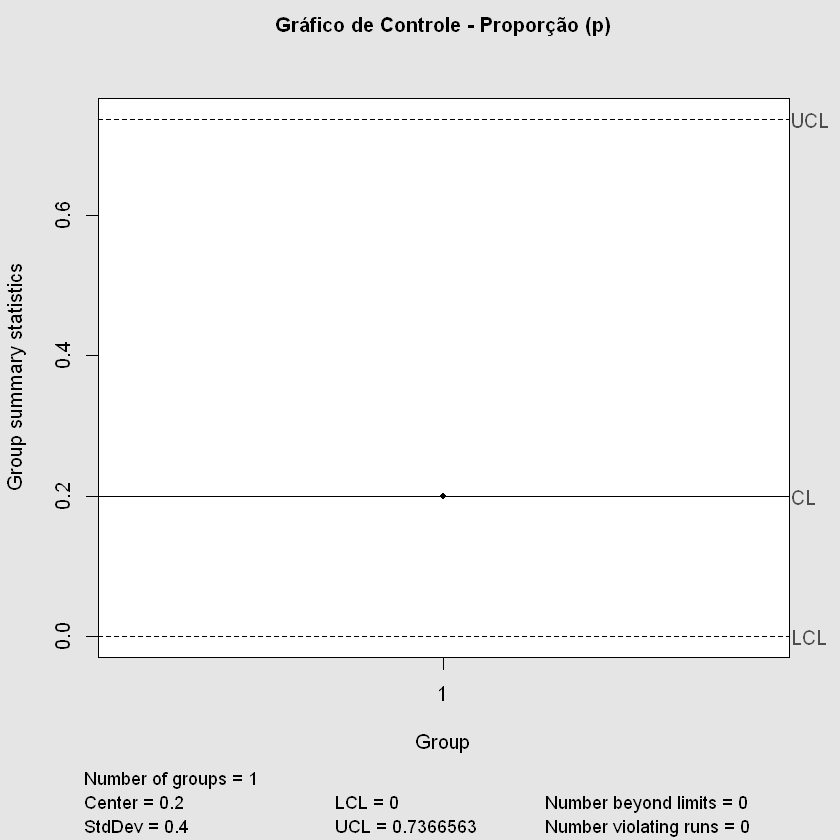


Call:
qcc(data = falhas_por_grupo, type = "p", sizes = rep(tamanho_grupo,     num_grupos), title = "Gráfico de Controle - Proporção (p)")

p chart for falhas_por_grupo 

Summary of group statistics:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.2     0.2     0.2     0.2     0.2     0.2 

Group sample size:  5
Number of groups:  1
Center of group statistics:  0.2
Standard deviation:  0.4 

Control limits:
 LCL       UCL
   0 0.7366563
✅ Processo está sob controle estatístico.
Nenhuma causa especial evidente.

📊 Comparação:
→ Gráficos por variáveis (x̄, R) são mais sensíveis a pequenas mudanças.
→ Gráficos por atributos (p, np) são mais simples, porém menos sensíveis.
✔ Use ambos em paralelo: atributos como monitoramento contínuo, variáveis para análises detalhadas.


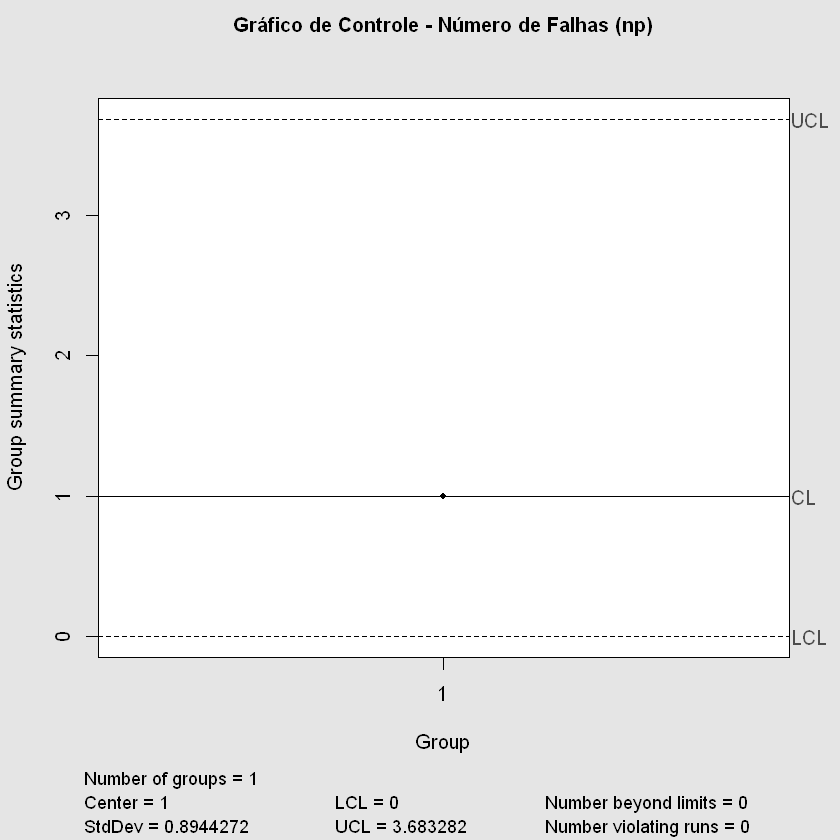

In [1]:
library(googlesheets4)
library(qcc)

# Se sua planilha for pública:
gs4_deauth()

# URL da planilha (substitua pelo seu link real)
url_planilha <- "https://docs.google.com/spreadsheets/d/1R0C885chVDklaK92j19qcCUZHnGzNtmLs7sYlQOmtd4/edit?gid=0#gid=0"

# Leitura dos dados da aba da vazão
dados_vazao <- read_sheet(url_planilha, sheet = 2)

# ===============================
# i) Análise estatística (atributo)
# ===============================

# Parâmetros
USL <- 1.1
LSL <- 0.9
tamanho_grupo <- 5

# Detectar não conformes
falhas_binarias <- ifelse(dados_vazao$`Q (L/min)` < LSL | dados_vazao$`Q (L/min)` > USL, 1, 0)

# Agrupar em subgrupos de tamanho 5
grupos <- split(falhas_binarias, ceiling(seq_along(falhas_binarias)/tamanho_grupo))
falhas_por_grupo <- sapply(grupos, sum)
num_grupos <- length(falhas_por_grupo)

# Proporção média
p_bar <- sum(falhas_por_grupo) / (tamanho_grupo * num_grupos)

# ===============================
# j) NMFA e NMA (distribuição binomial)
# ===============================

# Limites de controle para gráfico p
sigma_p <- sqrt(p_bar * (1 - p_bar) / tamanho_grupo)
LIC <- max(0, p_bar - 3 * sigma_p)
LSC <- min(1, p_bar + 3 * sigma_p)

# NMFA (erro tipo I): 1 / probabilidade de alarme sob p_bar
alpha <- 1 - (pbinom(LSC * tamanho_grupo, tamanho_grupo, p_bar) -
              pbinom(LIC * tamanho_grupo - 1, tamanho_grupo, p_bar))
NMFA <- ifelse(alpha > 0, 1 / alpha, Inf)

# NMA: tempo até alarme se p = 0.2 (desvio)
p1 <- 0.2
beta <- pbinom(LSC * tamanho_grupo, tamanho_grupo, p1) -
        pbinom(LIC * tamanho_grupo - 1, tamanho_grupo, p1)
NMA <- ifelse((1 - beta) > 0, 1 / (1 - beta), Inf)

cat("Proporção média de falhas (p̄):", round(p_bar, 4), "\n")
cat("LIC:", round(LIC, 4), " | LC:", round(p_bar, 4), " | LSC:", round(LSC, 4), "\n")
cat("NMFA (falsos alarmes):", round(NMFA, 2), "\n")
cat("NMA (tempo até alarme para p=0.2):", round(NMA, 2), "\n\n")

# ===============================
# k) Gráficos p e np
# ===============================

# Gráfico p
qcc_p <- qcc(falhas_por_grupo, type = "p", sizes = rep(tamanho_grupo, num_grupos), title = "Gráfico de Controle - Proporção (p)")

# Gráfico np
qcc_np <- qcc(falhas_por_grupo, type = "np", sizes = rep(tamanho_grupo, num_grupos), title = "Gráfico de Controle - Número de Falhas (np)")

# ===============================
# l) Padrões estranhos
# ===============================

summary(qcc_p)  # Avalia se há pontos fora dos limites ou tendências

# ===============================
# m) Processo estável?
# ===============================

if (all(qcc_p$violations$beyond.limits == FALSE)) {
  cat("✅ Processo está sob controle estatístico.\n")
} else {
  cat("⚠️ Há evidências de instabilidade no processo!\n")
}

# ===============================
# n) Causas especiais
# ===============================

if (length(qcc_p$violations$beyond.limits) > 0) {
  cat("🔍 Pontos fora do controle detectados nos subgrupos: ",
      paste(qcc_p$violations$beyond.limits, collapse = ", "), "\n")
  cat("→ Investigue o que ocorreu nestes pontos (ex: ajustes, falhas técnicas, variação humana).\n")
} else {
  cat("Nenhuma causa especial evidente.\n")
}

# ===============================
# o) Comparação atributos x variáveis
# ===============================

cat("\n📊 Comparação:\n")
cat("→ Gráficos por variáveis (x̄, R) são mais sensíveis a pequenas mudanças.\n")
cat("→ Gráficos por atributos (p, np) são mais simples, porém menos sensíveis.\n")
cat("✔ Use ambos em paralelo: atributos como monitoramento contínuo, variáveis para análises detalhadas.\n")
